# Project Title

**Authors:** Carlos McCrum, Micheal Lee, Doug Mill
***

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

***
Questions to consider:
* What are the business's pain points related to this project?
* How did you pick the data analysis question(s) that you did?
* Why are these questions important from a business perspective?
***

## Data Understanding

Describe the data being used for this project.
***
Questions to consider:
* Where did the data come from, and how do they relate to the data analysis questions?
* What do the data represent? Who is in the sample and what variables are included?
* What is the target variable?
* What are the properties of the variables you intend to use?
***

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import plot_confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, StandardScaler, label_binarize
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import CategoricalNB

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data Loading

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [42]:
df_crash = pd.read_csv('data/cleaned_data/cleaned_crash_data.csv')
columns_to_drop = ['LONGITUDE', 'LATITUDE', 'Unnamed: 0']
df_crash.drop((columns_to_drop), axis = 1, inplace = True)

In [43]:
df_crash['Target'].value_counts(normalize = True)

1    0.507418
4    0.385812
3    0.097288
2    0.009482
Name: Target, dtype: float64

In [24]:
df_vehicle = pd.read_csv('data/cleaned_data/cleaned_vehicle_data.csv')
columns_to_drop = ['Unnamed: 0']
df_vehicle.drop((columns_to_drop), axis = 1, inplace = True)

In [25]:
df_people = pd.read_csv('data/cleaned_data/cleaned_people_data.csv')
columns_to_drop = ['Unnamed: 0']
df_people.drop((columns_to_drop), axis = 1, inplace = True)

In [44]:
main_df = pd.read_csv('data/cleaned_data/cleaned_modeling_data.csv')
columns_to_drop = ['Unnamed: 0']
main_df.drop((columns_to_drop), axis = 1, inplace = True)

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

### First Simple Model (FSM) - "Dummy" Model

In [45]:
columns_to_drop = ['CRASH_RECORD_ID','CRASH_DATE', 'LONGITUDE', 'LATITUDE', 'Target']

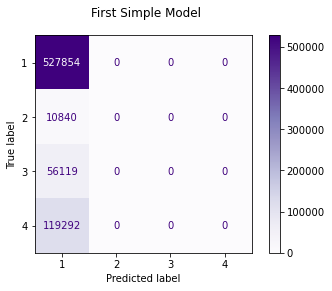

In [46]:
X = main_df.drop((columns_to_drop), axis=1)
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

fsm_dummy = DummyClassifier(strategy='most_frequent')
fsm_dummy.fit(X_train, y_train)

fsm_cv = cross_val_score(fsm_dummy, X_train, y_train, cv=5)
fsm_cv

fig, ax = plt.subplots()
fig.suptitle('First Simple Model')
plot_confusion_matrix(fsm_dummy, X_train, y_train, ax=ax, cmap='Purples');

In [47]:
dt = DecisionTreeClassifier(random_state = 1)

X = main_df.drop((columns_to_drop), axis = 1)
y = main_df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.7434873022874787

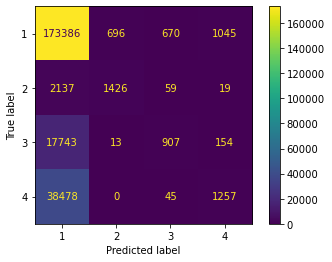

In [48]:
plot_confusion_matrix(dt, X_test, y_test)

In [49]:
bayes = CategoricalNB()
ohe = OneHotEncoder()
logreg = LinearSVC()
rf = RandomForestClassifier()
ovr = OneVsRestClassifier(logreg)

In [52]:
dt = DecisionTreeClassifier(random_state = 1, max_depth=100)
X = main_df.drop((columns_to_drop), axis=1)
y = main_df.Target

X = ohe.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [ ]:
ovr.fit(X_train, y_train)
dt.fit(X_train, y_train)
print('One vs Rest Score: {}'.format(ovr.score(X_train, y_train)))
print('Decision Tree Score: {}'.format(dt.score(X_train, y_train))) 

In [ ]:
plot_confusion_matrix(dt, X_test, y_test);

In [ ]:
# train_pred = ovr.predict(X_train)
# train_pred = label_binarize(train_pred, classes=len(main_df.Target1))
# y_test = label_binarize(y_test, classes=len(main_df.Target1))


In [ ]:
# roc_auc_score(y_train, train_pred, multi_class='ovo', average='macro')

In [ ]:
X2 = main_df.drop(['Target1', 'CRASH_RECORD_ID', 'MAKE', 'MODEL', 'CRASH_DATE', 'AGE'], axis=1)
y2 = main_df.Target1

X2 = ohe.fit_transform(X2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 1)


In [ ]:
ovr.fit(X_train2, y_train2)
dt.fit(X_train2, y_train2)
print('One vs Rest Score: {}'.format(ovr.score(X_train2, y_train2)))
print('Decision Tree Score: {}'.format(dt.score(X_train2, y_train2))) 

# Piplines

In [ ]:
pipeline_1 = Pipeline([('ss', StandardScaler()), 
                        ('RF', RandomForestClassifier(random_state = 1,  max_depth=100))])

In [ ]:
grid = [{'RF__max_depth': [4, 5, 6], 
         'RF__min_samples_split': [0.1, 1.0, 10], 
         'RF__min_samples_leaf': [0.1, 0.5, 5]}]
GS = GridSearchCV(estimator=pipeline_1, 
                          param_grid=grid, 
                          scoring='precision', 
                          cv=5)

In [ ]:
#GS.fit()

In [ ]:
#GS.cv_results_

In [ ]:
#GS.best_estimator_.score()

In [ ]:
#GS.best_params_

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***